### Section 1: Load headers

-- 21-Nov-19 : Reattempt at SMOTE for less data and simpler model

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
import matplotlib.pyplot as plt

from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn import metrics

from sklearn.preprocessing import LabelBinarizer
import seaborn as sns

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback

Using TensorFlow backend.


### Section 2: Load training data and target label

In [ ]:
path = ''
data = pd.read_excel('..\data\classwise_train\cardiomegaly.xlsx')

In [ ]:
data.shape

(46203, 6)

#### Section 2.a : Loading data from images and converting into numpy

In [ ]:
orig_path = 'CheXpert-v1.0-small'
opath_len = len(orig_path)
train_image = []
for image_path in data['Path'][:20000]:
    #print('../data' + image_path[opath_len:])
    img = image.load_img('../data' + image_path[opath_len:],target_size=(250,250,3))
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
    
train_data = np.array(train_image)

In [ ]:
train_data.shape

(20000, 250, 250, 3)

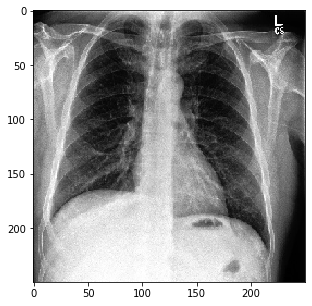

In [ ]:
rcParams['figure.figsize'] = 5, 5
plt.imshow(train_data[11])

In [ ]:
target_label = np.array(data[:20000].drop(['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA'],axis=1).fillna(0))

In [ ]:
target_label.shape

(20000, 1)

In [ ]:
np.unique(target_label, return_counts=True)

(array([-1,  0,  1], dtype=int64), array([ 3353,  5459, 11188], dtype=int64))

**Question to address, what to do with -1 class, drop? or combine with 0?**

In [ ]:
target_label[target_label<0] = 0
np.unique(target_label, return_counts=True)

(array([0, 1], dtype=int64), array([ 8812, 11188], dtype=int64))

#### Section 2.b: Dividing data into train-test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_data, target_label, random_state=42, test_size=0.2)

In [ ]:
# Clearing out memory
train_data = []
target_label = []

In [ ]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0, 1], dtype=int64), array([7057, 8943], dtype=int64))
(array([0, 1], dtype=int64), array([1755, 2245], dtype=int64))


In [ ]:
y_train = to_categorical(y_train.ravel())
y_test = to_categorical(y_test.ravel())

In [ ]:
y_train

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

### Section 3 : Defining the model

In [ ]:
num_classes = 2 ## For 1, 0 , -1
## CNN model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(250,250,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(num_classes, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 246, 246, 16)      1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 123, 123, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 123, 123, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 119, 119, 32)      12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 59, 59, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 59, 59, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 55, 55, 64)        51264     
__________

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
callbacks_list = [early_stop, reduce_lr]

#### Reattempt at SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
X_train.shape

(16000, 250, 250, 3)

In [ ]:
ReX_train = X_train.reshape(16000, 250 * 250 * 3)
ReX_train.shape

(16000, 187500)

In [ ]:
smt = SMOTE()
Xs_train, ys_train = smt.fit_sample(ReX_train, y_train)

In [ ]:
print(np.unique(ys_train, return_counts=True))

(array([0, 1]), array([8943, 8943], dtype=int64))


In [ ]:
Xs_train.shape

ys_train = to_categorical(ys_train.ravel())
ys_train.shape

(17886, 2)

In [ ]:
Xs_train.shape

(17886, 187500)

In [ ]:
Xs_train = Xs_train.reshape(17886, 250, 250, 3)

#### Section 4: Training the model

In [ ]:
model.fit(x = Xs_train, y = ys_train, batch_size = 32, epochs = 20, callbacks = callbacks_list, validation_data = (X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 17886 samples, validate on 4000 samples
Epoch 1/20
17886/17886 [==============================] - 80s 4ms/step - loss: 0.6823 - acc: 0.5545 - val_loss: 0.6714 - val_acc: 0.5925
Epoch 2/20
17886/17886 [==============================] - 68s 4ms/step - loss: 0.6253 - acc: 0.6643 - val_loss: 0.6169 - val_acc: 0.6827
Epoch 3/20
17886/17886 [==============================] - 67s 4ms/step - loss: 0.5809 - acc: 0.7025 - val_loss: 0.5823 - val_acc: 0.7055
Epoch 4/20
17886/17886 [==============================] - 67s 4ms/step - loss: 0.5684 - acc: 0.7155 - val_loss: 0.5562 - val_acc: 0.7245
Epoch 5/20
17886/17886 [==============================] - 68s 4ms/step - loss: 0.5607 - acc: 0.7225 - val_loss: 0.5963 - val_acc: 0.6930
Epoch 6/20
17886/17886 [==============================] - 68s 4ms/step - loss: 0.5481 - acc: 0.7336 - val_loss: 0.5597 - val_acc: 0.7315
Epoch 7/20
17886/17886 [==============================] - 68s 4ms/step - loss: 0.

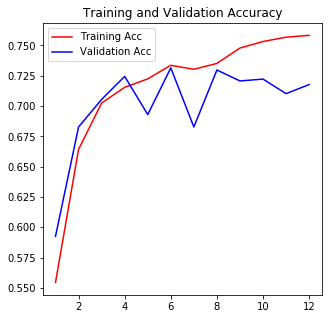

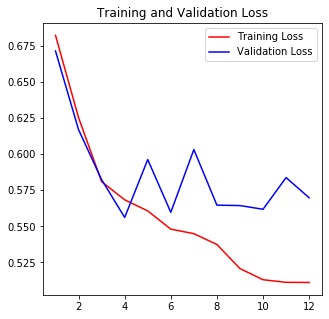

In [ ]:
train_acc = model.history.history['acc']
train_loss = model.history.history['loss']
val_acc = model.history.history['val_acc']
val_loss = model.history.history['val_loss']

epochs = range(1, len(train_acc)+1)

plt.plot(epochs, train_acc, 'r', label = 'Training Acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation Acc')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
plt.plot(epochs, train_loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Section 5: Predicting from valid data

In [ ]:
 #testing the model
path = ''
valid_data = pd.read_csv(path + '../data/valid.csv')
valid_data.columns

orig_path = 'CheXpert-v1.0-small'
opath_len = len(orig_path)
test_image = []
for image_path in valid_data['Path']:
    img = image.load_img('../data' + image_path[opath_len:],target_size=(250,250,3))
    img = image.img_to_array(img)
    img = img/255
    test_image.append(img)
    
test_data = np.array(test_image)

In [ ]:
path = ''
valid_data = pd.read_csv(path + '../data/valid.csv')
valid_data.columns

Index(['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices'],
      dtype='object')

In [ ]:
test_label = np.array(valid_data.drop(['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA'],axis=1).fillna(0))
ec_test_label = test_label[:,2:3]
print(valid_data.columns[5+2:6+2])
print(ec_test_label.shape)
np.unique(ec_test_label, return_counts=True)

Index(['Cardiomegaly'], dtype='object')
(234, 1)


(array([0., 1.]), array([166,  68], dtype=int64))

In [ ]:
y_orig = to_categorical(ec_test_label.ravel())
print(y_orig.shape)
pred = model.predict(test_data)
y_pred = np.where(pred > 0.5, 1.0, 0.0)

(234, 2)


### Section 6: Performance Evaluation Metrics

In [ ]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
        lb = LabelBinarizer()
        lb.fit(y_test)
        y_test = lb.transform(y_test)
        y_pred = lb.transform(y_pred)
        return metrics.roc_auc_score(y_test, y_pred, average=average)
        
def evaluate_model_performance_valid_data(y_orig, y_pred):
        accuracy = metrics.accuracy_score(y_orig, y_pred)
        print('Accuracy is:',accuracy)

        # For precision of each class individually use average= None
        precision = metrics.precision_score(y_orig, y_pred, average='macro')
        print('Precision is:',precision)

        # For recall of each class individually use average= None
        recall = metrics.recall_score(y_orig, y_pred, average='macro')
        print('Recall is:',recall)

        # For recall of each class individually use average= None
        f1_score_value = metrics.f1_score(y_orig, y_pred, average='macro')
        print('F1 Score is:',f1_score_value)
        
        # AUC Scores
        auc_score = multiclass_roc_auc_score(y_orig, y_pred)
        print('AUC score is:', auc_score)

        cm = metrics.confusion_matrix(y_orig.argmax(axis=1), y_pred.argmax(axis=1))
        print(cm)

        plt.figure(figsize=(5,5))
        sns.heatmap(cm, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues');
        plt.ylabel('Actual label');
        plt.xlabel('Predicted label');
        all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
        plt.title(all_sample_title, size = 12)

Accuracy is: 0.7521367521367521
Precision is: 0.6985930735930737
Recall is: 0.695074415308292
F1 Score is: 0.6967557422468496
AUC score is: 0.695074415308292
[[138  28]
 [ 30  38]]


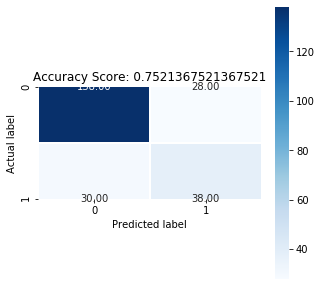

In [ ]:
evaluate_model_performance_valid_data(y_orig, y_pred)

## DenseNet121 trial

In [ ]:
# DenseNet Using Transfer Learning
from keras.applications import DenseNet121
conv_base = DenseNet121(include_top=False, weights='imagenet',input_shape=(250, 250, 3))

In [ ]:
num_classes = 2
from keras import models
from keras import layers
from keras import optimizers
model2 = models.Sequential()
model2.add(conv_base)
model2.add(Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.5))
#model.add(Dense(num_classes, activation='sigmoid'))
model2.add(Dense(num_classes, activation='softmax'))

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model2.fit(Xs_train, ys_train,
epochs=20,
batch_size=32,
validation_data=(X_test, y_test), callbacks = callbacks_list)

Train on 17886 samples, validate on 4000 samples
Epoch 1/20
17886/17886 [==============================] - 689s 39ms/step - loss: 3.0772 - acc: 0.5486 - val_loss: 0.7076 - val_acc: 0.4850
Epoch 2/20
17886/17886 [==============================] - 656s 37ms/step - loss: 1.1970 - acc: 0.5917 - val_loss: 0.6526 - val_acc: 0.6270
Epoch 3/20
17886/17886 [==============================] - 656s 37ms/step - loss: 0.9413 - acc: 0.6270 - val_loss: 0.6048 - val_acc: 0.7137
Epoch 4/20
17886/17886 [==============================] - 655s 37ms/step - loss: 0.9135 - acc: 0.6622 - val_loss: 0.6568 - val_acc: 0.6458
Epoch 5/20
17886/17886 [==============================] - 653s 37ms/step - loss: 1.0040 - acc: 0.5448 - val_loss: 6.0188 - val_acc: 0.4495
Epoch 6/20
17886/17886 [==============================] - 652s 36ms/step - loss: 0.9305 - acc: 0.5445 - val_loss: 0.6751 - val_acc: 0.6182
Epoch 7/20
17886/17886 [==============================] - 654s 37ms/step - loss: 0.9263 - acc: 0.6170 - val_loss: 0.6

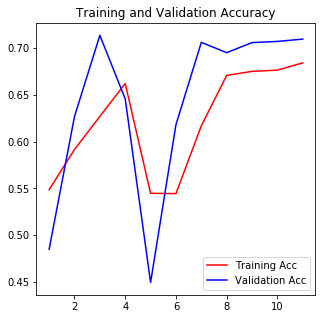

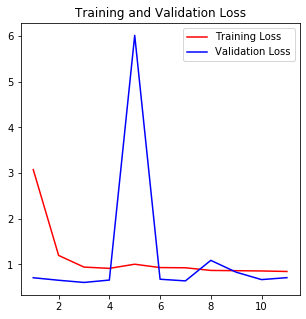

In [ ]:
train_acc = model2.history.history['acc']
train_loss = model2.history.history['loss']
val_acc = model2.history.history['val_acc']
val_loss = model2.history.history['val_loss']

epochs = range(1, len(train_acc)+1)

plt.plot(epochs, train_acc, 'r', label = 'Training Acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation Acc')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
plt.plot(epochs, train_loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
pred2 = model2.predict(test_data)
y_pred2 = np.where(pred2 > 0.5, 1.0, 0.0)

Accuracy is: 0.6709401709401709
Precision is: 0.6988438449566442
Recall is: 0.73768603827073
F1 Score is: 0.6634099867366572
AUC score is: 0.73768603827073
[[96 70]
 [ 7 61]]


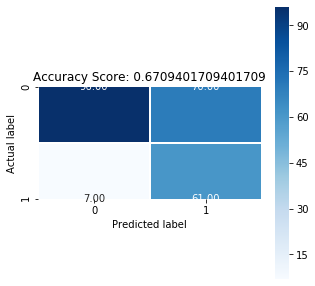

In [ ]:
evaluate_model_performance_valid_data(y_orig, y_pred2)